In [2]:
## Standard libraries
import os
import json
import math
import numpy as np
import copy
from typing import Any, Sequence, Callable, NamedTuple, Optional, Tuple
PyTree = Any  # Type definition for PyTree, for readability
from copy import deepcopy
import pickle

## Imports for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm

## JAX
import jax
import jax.numpy as jnp
from jax import random
from jax.tree_util import tree_map
# Seeding for random operations
main_rng = random.PRNGKey(42)

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training import train_state, checkpoints

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

/var/folders/f2/gq8xgm9x491cqwtct_tgpy0h0000gn/T/ipykernel_15123/316186734.py:17: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [3]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../../saved_models/tutorial4_jax"

# Verifying the device that will be used throughout this notebook
print("Device:", jax.devices()[0])

Device: METAL:0


In [4]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/JAX/tutorial4/"
# Files to download
pretrained_files = ["FashionMNIST_SGD.config",    "FashionMNIST_SGD_results.json",    "FashionMNIST_SGD.tar",
                    "FashionMNIST_SGDMom.config", "FashionMNIST_SGDMom_results.json", "FashionMNIST_SGDMom.tar",
                    "FashionMNIST_Adam.config",   "FashionMNIST_Adam_results.json",   "FashionMNIST_Adam.tar"   ]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [5]:
import torch
import torch.utils.data as data
from torchvision.datasets import FashionMNIST
from torchvision import transforms


In [6]:
# Transformations applied on each image => bring them into a numpy array and normalize to mean 0 and std 1
def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    img = (img / 255. - 0.2861) / 0.3530
    return img

# We need to stack the batch elements as numpy arrays
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root=DATASET_PATH,
                             train=True,
                             transform=image_to_numpy,
                             download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset,
                                                   [50000, 10000],
                                                   generator=torch.Generator().manual_seed(42))

# Loading the test set
test_set = FashionMNIST(root=DATASET_PATH,
                        train=False,
                        transform=image_to_numpy,
                        download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set,
                               batch_size=1024,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate)
val_loader   = data.DataLoader(val_set,
                               batch_size=1024,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate)
test_loader  = data.DataLoader(test_set,
                               batch_size=1024,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate)

In [7]:
print("Mean", (train_dataset.data.float() / 255.0).mean().item())
print("Std", (train_dataset.data.float() / 255.0).std().item())

Mean 0.28604060411453247
Std 0.3530242443084717


In [8]:
imgs, _ = next(iter(train_loader))
print(f"Mean: {imgs.mean().item():5.3f}")
print(f"Standard deviation: {imgs.std().item():5.3f}")
print(f"Maximum: {imgs.max().item():5.3f}")
print(f"Minimum: {imgs.min().item():5.3f}")

Mean: 0.008
Standard deviation: 1.009
Maximum: 2.022
Minimum: -0.810


In [9]:
# Network
class BaseNetwork(nn.Module):
    act_fn : Callable
    num_classes : int = 10
    hidden_sizes : Sequence = (512, 256, 256, 128)
    kernel_init : Callable = nn.linear.default_kernel_init

    @nn.compact
    def __call__(self, x, return_activations=False):
        x = x.reshape(x.shape[0], -1) # Reshape images to a flat vector
        # We collect all activations throughout the network for later visualizations
        # Remember that in jitted functions, unused tensors will anyways be removed.
        activations = []
        for hd in self.hidden_sizes:
            x = nn.Dense(hd,
                         kernel_init=self.kernel_init)(x)
            activations.append(x)
            x = self.act_fn(x)
            activations.append(x)
        x = nn.Dense(self.num_classes,
                     kernel_init=self.kernel_init)(x)
        activations.append(x)
        return x if not return_activations else (x, activations)

In [10]:
act_fn_by_name = {
    "tanh": nn.tanh,
    "relu": nn.relu,
    "identity": lambda x: x
}

In [11]:
##############################################################

def plot_dists(val_dict, color="C0", xlabel=None, stat="count", use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3, 2.5))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index%columns]
        sns.histplot(val_dict[key], ax=key_ax, color=color, bins=50, stat=stat,
                     kde=use_kde and ((val_dict[key].max()-val_dict[key].min())>1e-8)) # Only plot kde if there is variance
        key_ax.set_title(f"{key} " + (r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) if len(val_dict[key].shape)>1 else ""))
        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig

##############################################################

def visualize_weight_distribution(params, color="C0"):
    params, _ = jax.tree_util.tree_flatten(params)
    params = [p.reshape(-1) for p in params if len(p.shape) > 1]  # Remove biases
    params = jax.device_get(params)
    weights = {f'Layer {layer_idx*2}': p for layer_idx, p in enumerate(params)}

    ## Plotting
    fig = plot_dists(weights, color=color, xlabel="Weight vals")
    fig.suptitle("Weight distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

##############################################################

small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False, collate_fn=numpy_collate)
exmp_imgs, exmp_labels = next(iter(small_loader))

def visualize_gradients(model, params, color="C0", print_variance=False):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    # Pass one batch through the network, and calculate the gradients for the weights
    def loss_func(p):
        logits = model.apply(p, exmp_imgs)
        loss = optax.softmax_cross_entropy_with_integer_labels(logits, exmp_labels).mean()
        return loss
    grads = jax.grad(loss_func)(params)
    grads = jax.device_get(grads)
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = jax.tree_util.tree_leaves(grads)
    grads = [g.reshape(-1) for g in grads if len(g.shape) > 1]
    grads = {f'Layer {layer_idx*2}': g for layer_idx, g in enumerate(grads)}

    ## Plotting
    fig = plot_dists(grads, color=color, xlabel="Grad magnitude")
    fig.suptitle("Gradient distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(grads.keys()):
            print(f"{key} - Variance: {np.var(grads[key])}")

##############################################################

def visualize_activations(model, params, color="C0", print_variance=False):
    # Pass one batch through the network, and calculate the activations
    _, activations = model.apply(params, exmp_imgs, return_activations=True)
    activations = {f'Layer {layer_idx*2}': act.reshape(-1) for layer_idx, act in enumerate(activations[::2])}

    ## Plotting
    fig = plot_dists(activations, color=color, stat="density", xlabel="Activation vals")
    fig.suptitle("Activation distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(activations.keys()):
            print(f"{key} - Variance: {np.var(activations[key])}")


##############################################################

In [12]:
def init_simple_model(kernel_init, act_fn=act_fn_by_name['identity']):
    model = BaseNetwork(act_fn=act_fn,
                        kernel_init=kernel_init)
    params = model.init(random.PRNGKey(42), exmp_imgs)
    return model, params

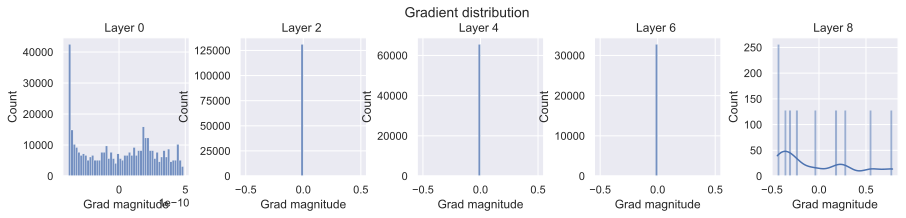

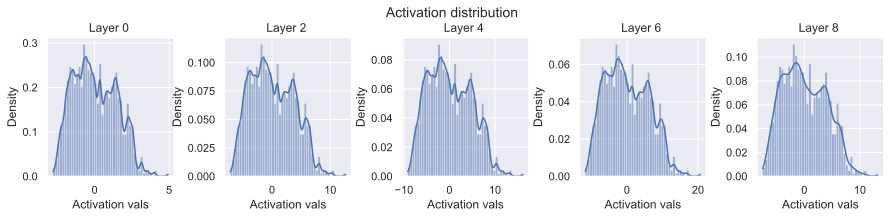

Layer 0 - Variance: 2.0582756996154785
Layer 2 - Variance: 13.489116668701172
Layer 4 - Variance: 22.100563049316406
Layer 6 - Variance: 36.20956039428711
Layer 8 - Variance: 14.831436157226562


In [13]:
# An initialization function in JAX takes as input a PRNG key,
# the shape of the parameter to create, and the data type
# (usually jnp.float32). We create this function based on the
# input parameter 'c' here, indicating the constant value
def get_const_init_func(c=0.0):
    return lambda key, shape, dtype: c*jnp.ones(shape, dtype=dtype)

model, params = init_simple_model(get_const_init_func(c=0.005))
visualize_gradients(model, params)
visualize_activations(model, params, print_variance=True)

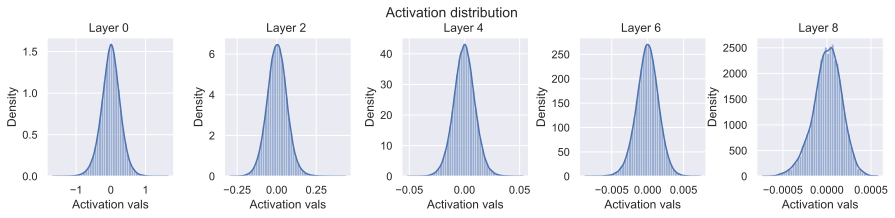

Layer 0 - Variance: 0.0773400068283081
Layer 2 - Variance: 0.004087541718035936
Layer 4 - Variance: 9.54908027779311e-05
Layer 6 - Variance: 2.41126917899237e-06
Layer 8 - Variance: 2.689677636169563e-08


In [14]:
def get_var_init_func(std=0.01):
    return lambda key, shape, dtype: std*random.normal(key, shape, dtype=dtype)

model, params = init_simple_model(get_var_init_func(std=0.01))
visualize_activations(model, params, print_variance=True)

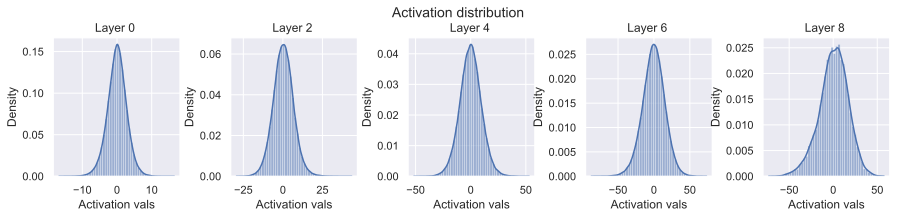

Layer 0 - Variance: 7.734001636505127
Layer 2 - Variance: 40.87541961669922
Layer 4 - Variance: 95.4908218383789
Layer 6 - Variance: 241.12701416015625
Layer 8 - Variance: 268.96783447265625


In [15]:
model, params = init_simple_model(get_var_init_func(std=0.1))
visualize_activations(model, params, print_variance=True)

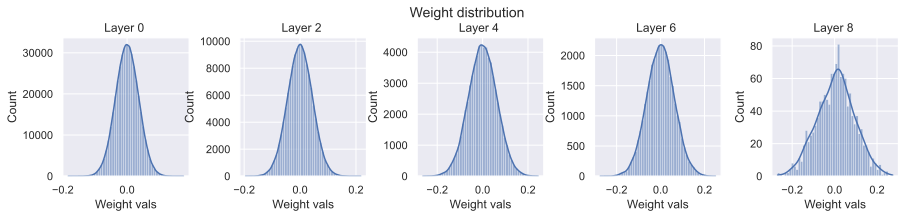

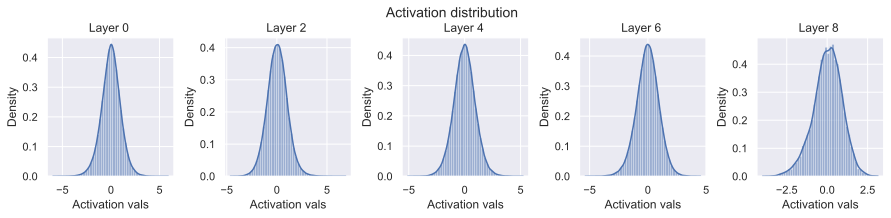

Layer 0 - Variance: 0.9864798784255981
Layer 2 - Variance: 1.018301248550415
Layer 4 - Variance: 0.9292565584182739
Layer 6 - Variance: 0.9166001081466675
Layer 8 - Variance: 0.7987748384475708


In [16]:
equal_var_init = lambda key, shape, dtype: 1.0/np.sqrt(shape[0]) * random.normal(key, shape, dtype=dtype)

model, params = init_simple_model(equal_var_init)
visualize_weight_distribution(params)
visualize_activations(model, params, print_variance=True)


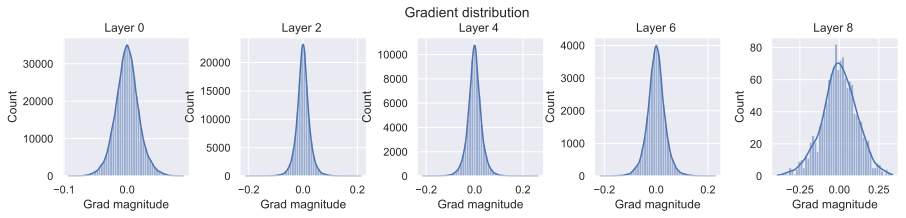

Layer 0 - Variance: 0.0003561964840628207
Layer 2 - Variance: 0.0006224004901014268
Layer 4 - Variance: 0.0008613402023911476
Layer 6 - Variance: 0.0012201354838907719
Layer 8 - Variance: 0.012633348815143108


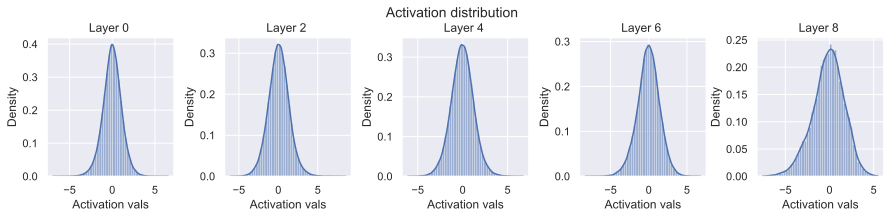

Layer 0 - Variance: 1.210919737815857
Layer 2 - Variance: 1.725461721420288
Layer 4 - Variance: 1.5787365436553955
Layer 6 - Variance: 2.1244356632232666
Layer 8 - Variance: 3.2292113304138184


In [17]:
def xavier_init(key, shape, dtype):
    bound = math.sqrt(6)/math.sqrt(shape[0]+shape[1])
    return random.uniform(key, shape, dtype,
                          minval=-bound, maxval=bound)

model, params = init_simple_model(xavier_init)
visualize_gradients(model, params, print_variance=True)
visualize_activations(model, params, print_variance=True)

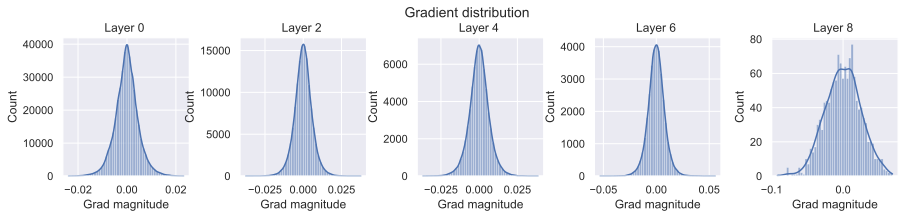

Layer 0 - Variance: 2.2197971702553332e-05
Layer 2 - Variance: 3.313149863970466e-05
Layer 4 - Variance: 4.1619066905695945e-05
Layer 6 - Variance: 6.094103446230292e-05
Layer 8 - Variance: 0.0006176179158501327


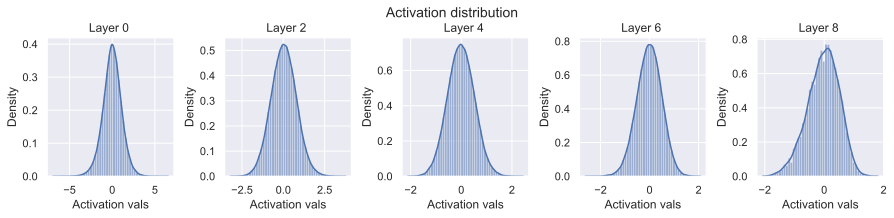

Layer 0 - Variance: 1.210919737815857
Layer 2 - Variance: 0.5825530886650085
Layer 4 - Variance: 0.27698078751564026
Layer 6 - Variance: 0.25604137778282166
Layer 8 - Variance: 0.28237906098365784


In [18]:
model, params = init_simple_model(xavier_init, act_fn=nn.tanh)
visualize_gradients(model, params, print_variance=True)
visualize_activations(model, params, print_variance=True)

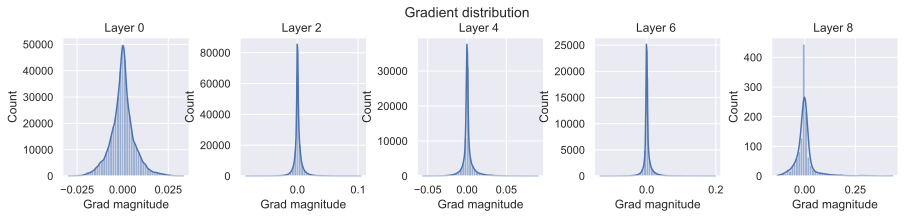

Layer 0 - Variance: 4.433344292920083e-05
Layer 2 - Variance: 5.4394578910432756e-05
Layer 4 - Variance: 6.247880810406059e-05
Layer 6 - Variance: 0.0001495712058385834
Layer 8 - Variance: 0.00263201049529016


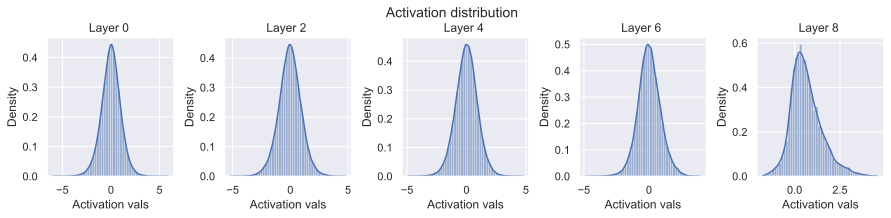

Layer 0 - Variance: 0.9864798784255981
Layer 2 - Variance: 0.9397588968276978
Layer 4 - Variance: 0.8418022394180298
Layer 6 - Variance: 0.7477067112922668
Layer 8 - Variance: 0.7288241982460022


In [19]:
num_input_feats = np.prod(exmp_imgs.shape[1:])
def kaiming_init(key, shape, dtype):
    # The first layer does not have ReLU applied on its input
    # Note that this detection only works if we do not use 784
    # feature size anywhere - better to explicitly handle
    # layer numbers
    if shape[0] == num_input_feats:
        std = 1/np.sqrt(shape[0])
    else:
        std = np.sqrt(2/shape[0])
    return std * random.normal(key, shape, dtype)

model, params = init_simple_model(kaiming_init, act_fn=nn.relu)
visualize_gradients(model, params, print_variance=True)
visualize_activations(model, params, print_variance=True)

In [20]:
def _get_config_file(model_path, model_name):
    # Name of the file for storing hyperparameter details
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    # Name of the file for storing network parameters
    return os.path.join(model_path, model_name + ".tar")

def _get_result_file(model_path, model_name):
    return os.path.join(model_path, model_name + "_results.json")

def load_model(model_path, model_name, state=None):
    """
    Loads a saved model from disk.

    Inputs:
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
        state - (Optional) If given, the parameters are loaded into this training state. Otherwise,
                a new one is created alongside a network architecture.
    """
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(config_file), f"Could not find the config file \"{config_file}\". Are you sure this is the correct path and you have your model config stored here?"
    assert os.path.isfile(model_file), f"Could not find the model file \"{model_file}\". Are you sure this is the correct path and you have your model stored here?"
    with open(config_file, "r") as f:
        config_dict = json.load(f)
    if state is None:
        net = BaseNetwork(act_fn=nn.relu, **config_dict)
        state = train_state.TrainState(step=0,
                                       params=None,
                                       apply_fn=net.apply,
                                       tx=None,
                                       opt_state=None)
    else:
        net = None
    # You can also use flax's checkpoint package. To show an alternative,
    # you can instead load the parameters simply from a pickle file.
    with open(model_file, 'rb') as f:
        params = pickle.load(f)
    state = state.replace(params=params)
    return state, net

def save_model(model, params, model_path, model_name):
    """
    Given a model, we save the parameters and hyperparameters.

    Inputs:
        model - Network object without parameters
        params - Parameters to save of the model
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
    """
    config_dict = {'hidden_sizes': model.hidden_sizes,
                   'num_classes': model.num_classes}
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    # You can also use flax's checkpoint package. To show an alternative,
    # you can instead save the parameters simply in a pickle file.
    with open(model_file, 'wb') as f:
        pickle.dump(params, f)

def calculate_loss(params, apply_fn, batch):
    imgs, labels = batch
    logits = apply_fn(params, imgs)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
    acc = (labels == logits.argmax(axis=-1)).mean()
    return loss, acc

@jax.jit
def train_step(state, batch):
    grad_fn = jax.value_and_grad(calculate_loss,
                                 has_aux=True)
    (_, acc), grads = grad_fn(state.params, state.apply_fn, batch)
    state = state.apply_gradients(grads=grads)
    return state, acc

@jax.jit
def eval_step(state, batch):
    _, acc = calculate_loss(state.params, state.apply_fn, batch)
    return acc

def train_model(net, params, optimizer, model_name, max_epochs=50, batch_size=256, overwrite=False):
    """
    Train a model on the training set of FashionMNIST

    Inputs:
        net - Object of BaseNetwork
        params - The parameters to use as initialization
        optimizer - Optimizer to use
        model_name - (str) Name of the model, used for creating the checkpoint names
        max_epochs - Number of epochs we want to (maximally) train for
        batch_size - Size of batches used in training
        overwrite - Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.
    """
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print("Model file already exists. Skipping training...")
        state = None
        with open(_get_result_file(CHECKPOINT_PATH, model_name), "r") as f:
            results = json.load(f)
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")

        # Initializing training state
        results = None
        state = train_state.TrainState.create(apply_fn=net.apply,
                                              params=params,
                                              tx=optimizer)

        # Defining data loader
        train_loader_local = data.DataLoader(train_set,
                                             batch_size=batch_size,
                                             shuffle=True,
                                             drop_last=True,
                                             collate_fn=numpy_collate,
                                             generator=torch.Generator().manual_seed(42))

        train_scores = []
        val_scores = []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            ############
            # Training #
            ############
            train_acc = 0.
            for batch in tqdm(train_loader_local, desc=f"Epoch {epoch+1}", leave=False):
                state, acc = train_step(state, batch)
                train_acc += acc
            train_acc /= len(train_loader_local)
            train_scores.append(train_acc.item())

            ##############
            # Validation #
            ##############
            val_acc = test_model(state, val_loader)
            val_scores.append(val_acc)
            print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc:05.2%}, Validation accuracy: {val_acc:4.2%}")

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, state.params, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch

    state, _ = load_model(CHECKPOINT_PATH, model_name, state=state)
    if results is None:
        test_acc = test_model(state, test_loader)
        results = {"test_acc": test_acc, "val_scores": val_scores,
                   "train_scores": train_scores}
        with open(_get_result_file(CHECKPOINT_PATH, model_name), "w") as f:
            json.dump(results, f)

    # Plot a curve of the validation accuracy
    sns.set()
    plt.plot([i for i in range(1,len(results["train_scores"])+1)], results["train_scores"], label="Train")
    plt.plot([i for i in range(1,len(results["val_scores"])+1)], results["val_scores"], label="Val")
    plt.xlabel("Epochs")
    plt.ylabel("Validation accuracy")
    plt.ylim(min(results["val_scores"]), max(results["train_scores"])*1.01)
    plt.title(f"Validation performance of {model_name}")
    plt.legend()
    plt.show()
    plt.close()

    print((f" Test accuracy: {results['test_acc']:4.2%} ").center(50, "=")+"\n")
    return state


def test_model(state, data_loader):
    """
    Test a model on a specified dataset.

    Inputs:
        state - Training state including parameters and model apply function.
        data_loader - DataLoader object of the dataset to test on (validation or test)
    """
    true_preds, count = 0., 0
    for batch in data_loader:
        acc = eval_step(state, batch)
        batch_size = batch[0].shape[0]
        true_preds += acc * batch_size
        count += batch_size
    test_acc = true_preds / count
    return test_acc.item()

In [21]:
class Optimizer(NamedTuple):
    # Given the parameters, initialize any optimizer state as tuple
    init : Callable[[PyTree], tuple]
    # Given the gradients, optimizer state, and evt. parameters, return
    # the parameter updates and new optimizer state
    update : Callable[[PyTree, tuple, Optional[PyTree]], Tuple[PyTree, tuple]]

In [24]:
#trying out pytree
pytree = {'a': [1, 2, 3], 'b': (4, 5), 'c': 6}
import jax
import jax.numpy as jnp

# Define the function to apply to each leaf
def increment(x):
    return x + 10

# Apply the function using tree_map
new_pytree = jax.tree_util.tree_map(increment, pytree)

print(new_pytree)
print(pytree)


{'a': [11, 12, 13], 'b': (14, 15), 'c': 16}
{'a': [1, 2, 3], 'b': (4, 5), 'c': 6}


In [25]:
def sgd(lr):
    def init(params):
        return tuple()

    def update(updates, state, params=None):
        updates = tree_map(lambda u: -lr * u, updates)
        return updates, state

    return Optimizer(init, update)

In [26]:
def sgd_momentum(lr, momentum=0.0):
    def init(params):
        param_momentum = tree_map(jnp.zeros_like, params)
        return param_momentum

    def update(updates, state, params=None):
        state = tree_map(lambda m, g: (1 - momentum) * g + momentum * m,
                         state,
                         updates)
        updates = tree_map(lambda m: - lr * m,
                           state)
        return updates, state

    return Optimizer(init, update)

In [27]:
def adam(lr, beta1=0.9, beta2=0.999, eps=1e-8):
    def init(params):
        step = 0.
        param_momentum = tree_map(jnp.zeros_like, params)
        param_2nd_momentum = tree_map(jnp.zeros_like, params)
        return (step, param_momentum, param_2nd_momentum)

    def update(updates, state, params=None):
        # Update momentum and adapt. lr
        step, param_momentum, param_2nd_momentum = state
        step += 1
        param_momentum = tree_map(lambda m, g: (1 - beta1) * g + beta1 * m,
                                  param_momentum,
                                  updates)
        param_2nd_momentum = tree_map(lambda m2, g: (1 - beta2) * g**2 + beta2 * m2,
                                      param_2nd_momentum,
                                      updates)
        # Calculate update for single parameter
        def update_param(m, m2):
            # Bias correction
            m /= 1 - beta1 ** step
            m2 /= 1 - beta2 ** step
            return - m * lr / (jnp.sqrt(m2) + eps)
        # Update for all parameters
        updates = tree_map(update_param,
                           param_momentum,
                           param_2nd_momentum)
        return updates, (step, param_momentum, param_2nd_momentum)

    return Optimizer(init, update)